In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'AAPL Stock Price'}, xlabel='Date'>

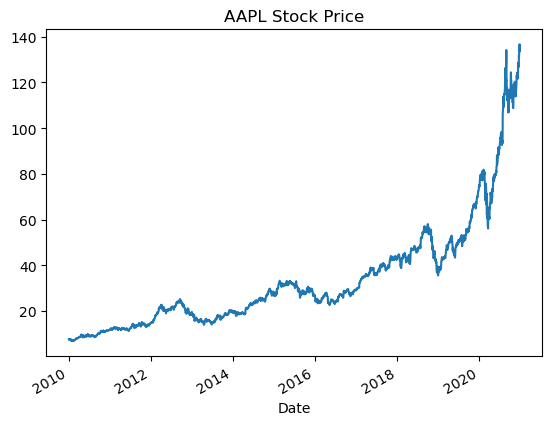

In [3]:
# Load historical stock price data
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2020-12-31')
data['Close'].plot(title=f'{ticker} Stock Price')


In [12]:
# Define SMA crossover strategies
sma_short_windows = [10, 20, 30]
sma_long_windows = [50, 100, 200]
strategies = [(short, long) for short in sma_short_windows for long in sma_long_windows if short < long]

# Function to calculate strategy returns
def calculate_sma_crossover_returns(data, short_window, long_window):
    data['SMA_short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['Close'].rolling(window=long_window).mean()
    data['Signal'] = 0
    data.loc[data.index[short_window:], 'Signal'] = np.where(data['SMA_short'][short_window:] > data['SMA_long'][short_window:], 1, -1)
    data['Returns'] = data['Close'].pct_change() * data['Signal'].shift(1)
    return data['Returns'].dropna()

# Function for Bonferroni correction
def bonferroni_correction(results, alpha):
    bonferroni_alpha = alpha / len(results)
    significant_results = [result for result in results if result[3] < bonferroni_alpha]
    return significant_results

# Function for Šidák correction
def sidak_correction(results, alpha):
    sidak_alpha = 1 - (1 - alpha)**(1 / len(results))
    significant_results = [result for result in results if result[3] < sidak_alpha]
    return significant_results

# Test each strategy for statistical significance
results = []
for short, long in strategies:
    returns = calculate_sma_crossover_returns(data.copy(), short, long)
    t_stat, p_value = ttest_1samp(returns, 0)
    results.append((short, long, np.mean(returns), p_value))

# Apply Bonferroni correction
alpha = 0.05
significant_bonferroni = bonferroni_correction(results, alpha)

# Apply Šidák correction
significant_sidak = sidak_correction(results, alpha)

# Display significant results for Bonferroni correction
if significant_bonferroni:
    print("Significant SMA Crossover Strategies after Bonferroni Correction:")
    for short, long, mean_return, p_value in significant_bonferroni:
        print(f"Short Window: {short}, Long Window: {long}, Mean Return: {mean_return:.5f}, P-value: {p_value:.5f}")
else:
    print("No significant SMA crossover strategies found after Bonferroni correction.")

# Display significant results for Šidák correction
if significant_sidak:
    print("\nSignificant SMA Crossover Strategies after Šidák Correction:")
    for short, long, mean_return, p_value in significant_sidak:
        print(f"Short Window: {short}, Long Window: {long}, Mean Return: {mean_return:.5f}, P-value: {p_value:.5f}")
else:
    print("No significant SMA crossover strategies found after Šidák correction.")

No significant SMA crossover strategies found after Bonferroni correction.
No significant SMA crossover strategies found after Šidák correction.


In [14]:
results # last column is single test p value

[(10, 50, 0.000512289363932418, 0.13118682052911085),
 (10, 100, 0.0004231595285389828, 0.2124930325131717),
 (10, 200, 0.0007166384786286564, 0.034689838452122666),
 (20, 50, 0.0004511123084211513, 0.18199829328655345),
 (20, 100, 0.00045526077266665963, 0.17801088047815056),
 (20, 200, 0.0006748013066132693, 0.04584524689913925),
 (30, 50, 0.00024585204450365674, 0.4663542314843435),
 (30, 100, 0.0002630071782507953, 0.4358281601178364),
 (30, 200, 0.0007956413418490174, 0.018351847761111685)]